# Evaluation

This notebook create graphs that report the training performance of all trained (six) RL models. It plots the cross-model episodic reward, f-signal (derived from MI) and g-signal (derived from electricity cost) of all models during training, and plots comparison plots across discrete (DDQL-MI) and continuous (PPO-MI) models under same lambda-value.

In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from utils import print_log

In [ ]:
# Change the datetime according to your experiment.
# Also feel free to extend this dictionary with your own experiments.
# "discrete" represents DDQL-MI algo, "continuous" represents our PPO-MI algo.
# format: (action_type: "discrete" | "continuous", reward_lambda): datetime
expt_datetime_dict = {
    ("discrete", "0.0"): datetime(2025, 8, 13, 23, 23, 31),
    ("discrete", "0.5"): datetime(2025, 8, 14, 2, 5, 26),
    ("discrete", "1.0"): datetime(2025, 8, 14, 4, 46, 19),
    ("continuous", "0.0"): datetime(2025, 8, 11, 2, 46, 31),
    ("continuous", "0.5"): datetime(2025, 8, 11, 4, 45, 55),
    ("continuous", "1.0"): datetime(2025, 8, 11, 6, 42, 39),
}

In [3]:
expt_folders = {
    k: Path("experiments") / (v.strftime("%Y%m%d_%H%M%S") + "_action_" + k[0] + "_reward_lambda_" + k[1]) for k, v in expt_datetime_dict.items()
}

# check if all folders exist
for folder in expt_folders.values():
    if not folder.exists():
        print_log(f"Experiment folder {folder} does not exist. Please check the experiment datetime and action type.")
        raise FileNotFoundError(f"Experiment folder {folder} does not exist.")
    else:
        print_log(f"Experiment folder {folder} exists.")
    
expt_train_folders = {
    k: v / ("logs_train") for k, v in expt_folders.items()
}

[2025-09-22 22:42:12:140] Experiment folder experiments/20250813_232331_action_discrete_reward_lambda_0.0 exists.
[2025-09-22 22:42:12:140] Experiment folder experiments/20250814_020526_action_discrete_reward_lambda_0.5 exists.
[2025-09-22 22:42:12:140] Experiment folder experiments/20250814_044619_action_discrete_reward_lambda_1.0 exists.
[2025-09-22 22:42:12:140] Experiment folder experiments/20250811_024631_action_continuous_reward_lambda_0.0 exists.
[2025-09-22 22:42:12:140] Experiment folder experiments/20250811_044555_action_continuous_reward_lambda_0.5 exists.
[2025-09-22 22:42:12:140] Experiment folder experiments/20250811_064239_action_continuous_reward_lambda_1.0 exists.


In [4]:
output_folder = Path("experiments_graphs")

if not output_folder.exists():
    output_folder.mkdir(parents=True)

In [5]:
def load_all_training_episode_data(expt_train_folders):
    """
    Load episode information data from all experiment training folders.
    
    Args:
        expt_train_folders: dict with keys (action_space, lambda_value) and values as Path objects
                           to training folders containing episode_info subdirectories
    
    Returns:
        dict: Same keys as input, values are tuples of (episode_metadata_df, episode_info_dfs)
    """
    all_results = {}
    
    # Helper function to flatten nested dictionaries
    def flatten(d, parent_key='', sep='_'):
        items = []
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            if isinstance(v, dict):
                items.extend(flatten(v, new_key, sep=sep).items())
            else:
                items.append((new_key, v))
        return dict(items)
    
    for key, expt_phrase_folder in expt_train_folders.items():
        print_log(f"Loading data for experiment {key}: {expt_phrase_folder}")
        
        # Load episode information data
        episode_info_folder = expt_phrase_folder / "episode_info"
        if episode_info_folder.exists():
            episode_info_files = sorted(list(episode_info_folder.glob("*.json")))
            episode_info_dfs = []
            episode_metadata_list = []

            print_log(f"Loading {len(episode_info_files)} episode files for {key}...")
            
            for file in episode_info_files:
                with open(file, "r") as f:
                    episode_info = json.load(f)
                    
                    # Extract episode data and metadata (support new format)
                    if isinstance(episode_info, dict) and 'episode_data' in episode_info:
                        # New format with metadata
                        episode_data = episode_info['episode_data']
                        metadata = episode_info.get('metadata', {})
                        df = pd.DataFrame(episode_data)

                        metadata = flatten(metadata)  # Flatten metadata dictionary
                        
                        # Store metadata for analysis
                        episode_metadata_list.append({
                            'episode_file': file.name,
                            **metadata
                        })

                    # Add episode number column
                    df['episode'] = int(file.stem.split('_')[1])
                    df['episode_index'] = len(episode_info_dfs)                     # Add episode index for plotting
                    df['episode_data_idx'] = metadata.get('episode_data_idx', 0)    # Add episode data index
                    
                    # Convert datetime strings to datetime objects
                    if 'datetime' in df.columns:
                        df['datetime'] = pd.to_datetime(df['datetime'], format='ISO8601')
                    
                    # Temporary fix: shift some columns forward by one timestep
                    shift_columns = ['grid_load (W)', 'action (kW)', 'battery_action (kW)', 'reward', 
                                   'f_signal', 'g_signal', 'f_signal-predicted_mean', 
                                   'f_signal-predicted_log_var', 'f_signal-target', 'f_signal-loss']
                    
                    for col in shift_columns:
                        if col in df.columns:
                            df[col] = df[col].shift(-1)
                    
                    # Remove the last row for each episode
                    df = df[:-1]

                    # temporary fix for grid load calculation (once)
                    df['grid_load (W)'] = df['user_load (W)'] + df['battery_action (kW)'] * 1000
                    
                    episode_info_dfs.append(df)

            # Create episode metadata DataFrame for curriculum analysis
            episode_metadata_df = pd.DataFrame(episode_metadata_list)
            
            print_log(f"Loaded {len(episode_info_dfs)} episodes for {key}")
            print_log(f"Episode metadata shape for {key}: {episode_metadata_df.shape}")
            
            all_results[key] = (episode_metadata_df, episode_info_dfs)
            
        else:
            print_log(f"Episode info folder {episode_info_folder} does not exist for {key}.")
            all_results[key] = (None, None)
    
    return all_results

In [6]:
# Load all training episode data from experiment folders
all_training_data = load_all_training_episode_data(expt_train_folders)

# Display summary of loaded data
for key, (episode_metadata_df, episode_info_dfs) in all_training_data.items():
    if episode_info_dfs is not None:
        print_log(f"Experiment {key}: {len(episode_info_dfs)} episodes loaded")
    else:
        print_log(f"Experiment {key}: No data found")

[2025-09-22 22:42:15:819] Loading data for experiment ('discrete', '0.0'): experiments/20250813_232331_action_discrete_reward_lambda_0.0/logs_train
[2025-09-22 22:42:15:822] Loading 805 episode files for ('discrete', '0.0')...
[2025-09-22 22:42:21:466] Loaded 805 episodes for ('discrete', '0.0')
[2025-09-22 22:42:21:466] Episode metadata shape for ('discrete', '0.0'): (805, 9)
[2025-09-22 22:42:21:466] Loading data for experiment ('discrete', '0.5'): experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train
[2025-09-22 22:42:21:468] Loading 805 episode files for ('discrete', '0.5')...
[2025-09-22 22:42:27:160] Loaded 805 episodes for ('discrete', '0.5')
[2025-09-22 22:42:27:160] Episode metadata shape for ('discrete', '0.5'): (805, 9)
[2025-09-22 22:42:27:160] Loading data for experiment ('discrete', '1.0'): experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train
[2025-09-22 22:42:27:163] Loading 805 episode files for ('discrete', '1.0')...
[2025-09-22 2

In [7]:
def plot_cross_model_training_rewards(all_training_data, window_size=100, show=True, save_path=None):
    """
    Plots overall episodic training reward for all models with rolling average and original reward curves.
    
    Args:
        all_training_data: dict with keys (action_space, lambda_value) and values (episode_metadata_df, episode_info_dfs)
        window_size: int, window for rolling average (default: 100)
        show: bool, whether to show plot (default: True)
        save_path: str or None, path to save figure (default: None)
    """
    
    # Extract reward data for each experiment
    model_results_dict = {}
    
    for key, (episode_metadata_df, episode_info_dfs) in all_training_data.items():
        if episode_info_dfs is not None and len(episode_info_dfs) > 0:
            action_space, lambda_value = key
            
            # Calculate total reward per episode
            episode_rewards = []
            for episode_df in episode_info_dfs:
                if 'reward' in episode_df.columns:
                    total_reward = episode_df['reward'].sum()
                    episode_rewards.append(total_reward)
            
            if episode_rewards:
                # Map action space to algorithm name
                algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
                model_results_dict[key] = {
                    'reward': episode_rewards,
                    'label': f'{algo_name} λ={lambda_value}'
                }
    
    if not model_results_dict:
        print_log("No valid training data found for plotting.")
        return None
    
    # Assign colors for each lambda value
    unique_lambdas = sorted(set([k[1] for k in model_results_dict.keys()]))
    base_palette = sns.color_palette('tab10', n_colors=len(unique_lambdas))
    lambda_color_map = {lam: base_palette[i] for i, lam in enumerate(unique_lambdas)}
    
    # For each lambda, create saturated (continuous) and pale (discrete) variants
    def adjust_color(color, saturation):
        # Simple saturation adjustment: interpolate towards white
        return tuple([saturation * c + (1-saturation) * 1.0 for c in color])
    
    action_space_saturation = {'continuous': 1.0, 'discrete': 0.5}
    
    plt.figure(figsize=(12, 7), dpi=150)
    
    for (action_space, lambda_value), result in model_results_dict.items():
        rewards = np.array(result['reward'])
        label = result['label']
        
        color_base = lambda_color_map[lambda_value]
        color = adjust_color(color_base, action_space_saturation[action_space])
        
        # Rolling average using pandas rolling (handles edge cases better)
        rewards_series = pd.Series(rewards)
        rolling_avg = rewards_series.rolling(window=window_size, min_periods=1).mean()
        
        # Plot original reward curve (low alpha)
        plt.plot(np.arange(len(rewards)), rewards, color=color, alpha=0.2, linewidth=1)
        
        # Plot rolling average curve (main curve)
        plt.plot(np.arange(len(rewards)), rolling_avg, color=color, alpha=1.0, linewidth=2, label=label)
    
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Total Episode Reward', fontsize=12)
    plt.title(f'Cross-Model Training Performance (Rolling Average Window={window_size})', fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print_log(f"Plot saved to: {save_path}")
    
    if show:
        plt.show()
    
    # Print summary statistics
    print_log("\nTraining Performance Summary:")
    for (action_space, lambda_value), result in model_results_dict.items():
        rewards = np.array(result['reward'])
        final_avg = pd.Series(rewards).rolling(window=window_size, min_periods=1).mean().iloc[-1]
        algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
        print_log(f"{algo_name} λ={lambda_value}: {len(rewards)} episodes, Final {window_size}-episode avg: {final_avg:.2f}")
    
    return plt.gcf()

[2025-09-22 22:51:25:643] Plot saved to: experiments_graphs/cross_model_training_rewards_20250922.pdf


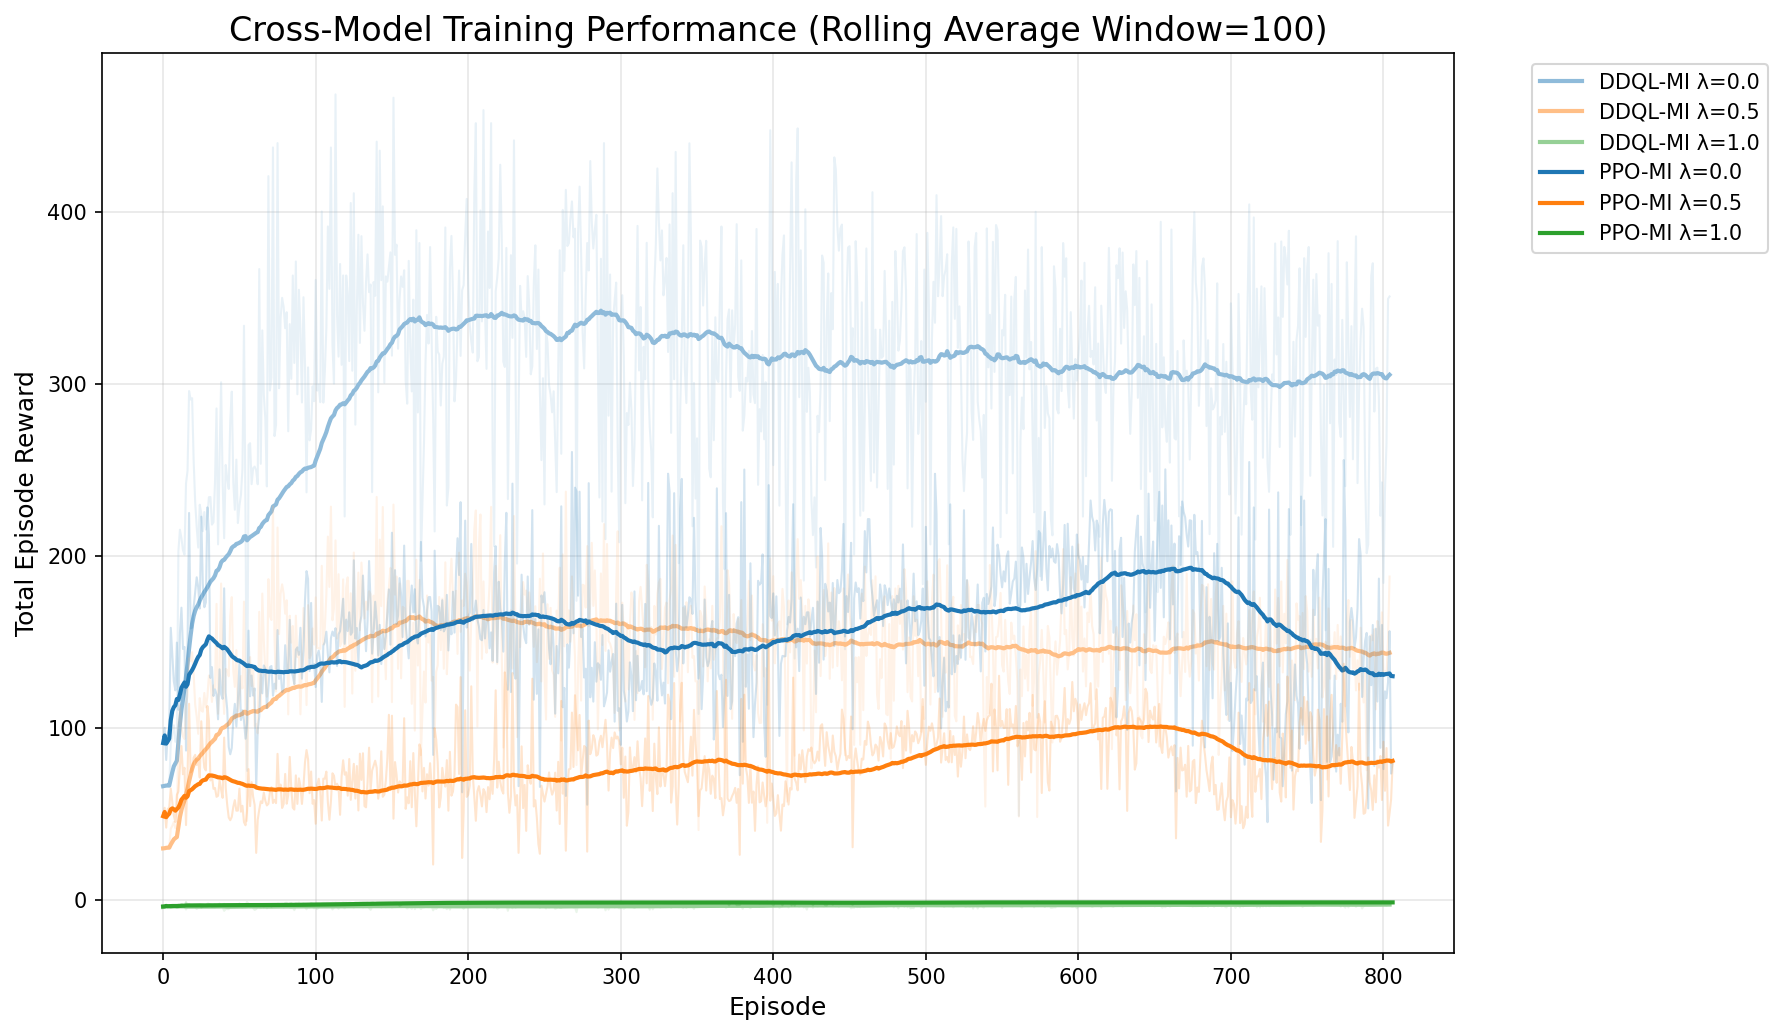

[2025-09-22 22:51:25:779] 
Training Performance Summary:
[2025-09-22 22:51:25:780] DDQL-MI λ=0.0: 805 episodes, Final 100-episode avg: 305.47
[2025-09-22 22:51:25:780] DDQL-MI λ=0.5: 805 episodes, Final 100-episode avg: 143.74
[2025-09-22 22:51:25:780] DDQL-MI λ=1.0: 805 episodes, Final 100-episode avg: -2.63
[2025-09-22 22:51:25:781] PPO-MI λ=0.0: 807 episodes, Final 100-episode avg: 130.19
[2025-09-22 22:51:25:781] PPO-MI λ=0.5: 807 episodes, Final 100-episode avg: 80.91
[2025-09-22 22:51:25:781] PPO-MI λ=1.0: 807 episodes, Final 100-episode avg: -1.37


<Figure size 640x480 with 0 Axes>

In [8]:
# Test the cross-model training rewards plot
fig = plot_cross_model_training_rewards(
    all_training_data, 
    window_size=100, 
    show=True, 
    save_path=output_folder / f"cross_model_training_rewards_{datetime(2025, 9, 22).strftime('%Y%m%d')}.pdf"
)

In [9]:
def plot_cross_model_episodic_f_signal(all_training_data, window_size=100, show=True, save_path=None):
    """
    Plots episodic sum of f-signal for all models with rolling average and original signal curves.
    
    Args:
        all_training_data: dict with keys (action_space, lambda_value) and values (episode_metadata_df, episode_info_dfs)
        window_size: int, window for rolling average (default: 100)
        show: bool, whether to show plot (default: True)
        save_path: str or None, path to save figure (default: None)
    """
    
    # Extract f-signal data for each experiment
    model_results_dict = {}
    
    for key, (episode_metadata_df, episode_info_dfs) in all_training_data.items():
        if episode_info_dfs is not None and len(episode_info_dfs) > 0:
            action_space, lambda_value = key
            
            # Calculate total f-signal per episode
            episode_f_signals = []
            for episode_df in episode_info_dfs:
                if 'f_signal' in episode_df.columns:
                    total_f_signal = episode_df['f_signal'].sum()
                    episode_f_signals.append(total_f_signal)
            
            if episode_f_signals:
                # Map action space to algorithm name
                algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
                model_results_dict[key] = {
                    'f_signal': episode_f_signals,
                    'label': f'{algo_name} λ={lambda_value}'
                }
    
    if not model_results_dict:
        print_log("No valid f-signal data found for plotting.")
        return None
    
    # Assign colors for each lambda value using tab10 palette
    unique_lambdas = sorted(set([k[1] for k in model_results_dict.keys()]))
    base_palette = sns.color_palette('tab10', n_colors=len(unique_lambdas))
    lambda_color_map = {lam: base_palette[i] for i, lam in enumerate(unique_lambdas)}
    
    # For each lambda, create saturated (continuous) and pale (discrete) variants
    def adjust_color(color, saturation):
        # Simple saturation adjustment: interpolate towards white
        return tuple([saturation * c + (1-saturation) * 1.0 for c in color])
    
    action_space_saturation = {'continuous': 1.0, 'discrete': 0.5}
    
    plt.figure(figsize=(12, 7), dpi=150)
    
    for (action_space, lambda_value), result in model_results_dict.items():
        f_signals = np.array(result['f_signal'])
        label = result['label']
        
        color_base = lambda_color_map[lambda_value]
        color = adjust_color(color_base, action_space_saturation[action_space])
        
        # Rolling average using pandas rolling (handles edge cases better)
        f_signals_series = pd.Series(f_signals)
        rolling_avg = f_signals_series.rolling(window=window_size, min_periods=1).mean()
        
        # Plot original f-signal curve (low alpha)
        plt.plot(np.arange(len(f_signals)), f_signals, color=color, alpha=0.2, linewidth=1)
        
        # Plot rolling average curve (main curve)
        plt.plot(np.arange(len(f_signals)), rolling_avg, color=color, alpha=1.0, linewidth=2, label=label)
    
    plt.xlabel('Episode')
    plt.ylabel('Total Episode F-Signal')
    plt.title(f'Cross-Model F-Signal Performance (Rolling Average Window={window_size})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print_log(f"F-signal plot saved to: {save_path}")
    
    if show:
        plt.show()
    
    # Print summary statistics
    print_log("\nF-Signal Performance Summary:")
    for (action_space, lambda_value), result in model_results_dict.items():
        f_signals = np.array(result['f_signal'])
        final_avg = pd.Series(f_signals).rolling(window=window_size, min_periods=1).mean().iloc[-1]
        algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
        print_log(f"{algo_name} λ={lambda_value}: {len(f_signals)} episodes, Final {window_size}-episode avg: {final_avg:.2f}")
    
    return plt.gcf()

[2025-08-25 18:39:21:264] F-signal plot saved to: experiments_graphs/cross_model_f_signal_performance.svg


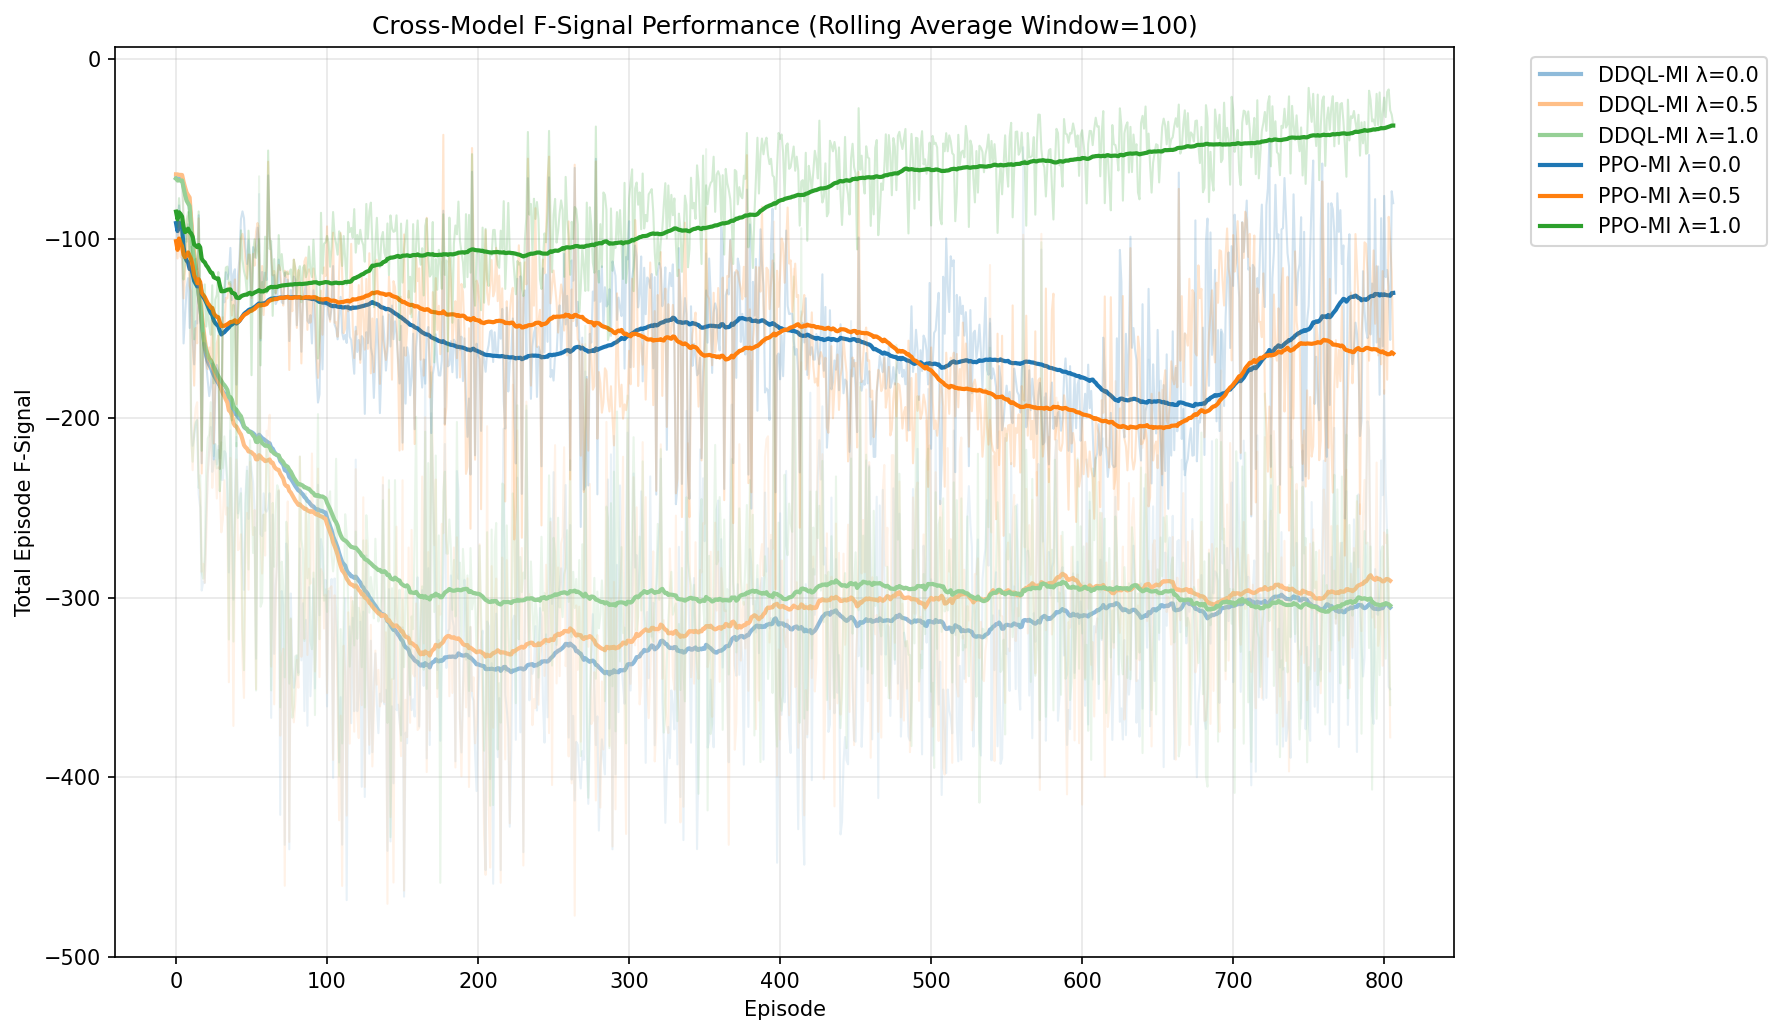

[2025-08-25 18:39:21:420] 
F-Signal Performance Summary:
[2025-08-25 18:39:21:421] DDQL-MI λ=0.0: 805 episodes, Final 100-episode avg: -305.47
[2025-08-25 18:39:21:422] DDQL-MI λ=0.5: 805 episodes, Final 100-episode avg: -290.54
[2025-08-25 18:39:21:422] DDQL-MI λ=1.0: 805 episodes, Final 100-episode avg: -304.38
[2025-08-25 18:39:21:422] PPO-MI λ=0.0: 807 episodes, Final 100-episode avg: -130.19
[2025-08-25 18:39:21:422] PPO-MI λ=0.5: 807 episodes, Final 100-episode avg: -163.94
[2025-08-25 18:39:21:422] PPO-MI λ=1.0: 807 episodes, Final 100-episode avg: -36.94


<Figure size 640x480 with 0 Axes>

In [10]:
# Plot cross-model f-signal performance
fig_f_signal = plot_cross_model_episodic_f_signal(
    all_training_data, 
    window_size=100, 
    show=True, 
    save_path=output_folder / "cross_model_f_signal_performance.svg"
)

In [11]:
def plot_cross_model_episodic_g_signal(all_training_data, window_size=100, show=True, save_path=None):
    """
    Plots episodic sum of g-signal for all models with rolling average and original signal curves.
    
    Args:
        all_training_data: dict with keys (action_space, lambda_value) and values (episode_metadata_df, episode_info_dfs)
        window_size: int, window for rolling average (default: 100)
        show: bool, whether to show plot (default: True)
        save_path: str or None, path to save figure (default: None)
    """
    
    # Extract g-signal data for each experiment
    model_results_dict = {}
    
    for key, (episode_metadata_df, episode_info_dfs) in all_training_data.items():
        if episode_info_dfs is not None and len(episode_info_dfs) > 0:
            action_space, lambda_value = key
            
            # Calculate total g-signal per episode
            episode_g_signals = []
            for episode_df in episode_info_dfs:
                if 'g_signal' in episode_df.columns:
                    total_g_signal = episode_df['g_signal'].sum()
                    episode_g_signals.append(total_g_signal)
            
            if episode_g_signals:
                # Map action space to algorithm name
                algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
                model_results_dict[key] = {
                    'g_signal': episode_g_signals,
                    'label': f'{algo_name} λ={lambda_value}'
                }
    
    if not model_results_dict:
        print_log("No valid g-signal data found for plotting.")
        return None
    
    # Assign colors for each lambda value using tab10 palette
    unique_lambdas = sorted(set([k[1] for k in model_results_dict.keys()]))
    base_palette = sns.color_palette('tab10', n_colors=len(unique_lambdas))
    lambda_color_map = {lam: base_palette[i] for i, lam in enumerate(unique_lambdas)}
    
    # For each lambda, create saturated (continuous) and pale (discrete) variants
    def adjust_color(color, saturation):
        # Simple saturation adjustment: interpolate towards white
        return tuple([saturation * c + (1-saturation) * 1.0 for c in color])
    
    action_space_saturation = {'continuous': 1.0, 'discrete': 0.5}
    
    plt.figure(figsize=(12, 7), dpi=150)
    
    for (action_space, lambda_value), result in model_results_dict.items():
        g_signals = np.array(result['g_signal'])
        label = result['label']
        
        color_base = lambda_color_map[lambda_value]
        color = adjust_color(color_base, action_space_saturation[action_space])
        
        # Rolling average using pandas rolling (handles edge cases better)
        g_signals_series = pd.Series(g_signals)
        rolling_avg = g_signals_series.rolling(window=window_size, min_periods=1).mean()
        
        # Plot original g-signal curve (low alpha)
        plt.plot(np.arange(len(g_signals)), g_signals, color=color, alpha=0.2, linewidth=1)
        
        # Plot rolling average curve (main curve)
        plt.plot(np.arange(len(g_signals)), rolling_avg, color=color, alpha=1.0, linewidth=2, label=label)
    
    plt.xlabel('Episode')
    plt.ylabel('Total Episode G-Signal')
    plt.title(f'Cross-Model G-Signal Performance (Rolling Average Window={window_size})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print_log(f"G-signal plot saved to: {save_path}")
    
    if show:
        plt.show()
    
    # Print summary statistics
    print_log("\nG-Signal Performance Summary:")
    for (action_space, lambda_value), result in model_results_dict.items():
        g_signals = np.array(result['g_signal'])
        final_avg = pd.Series(g_signals).rolling(window=window_size, min_periods=1).mean().iloc[-1]
        algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
        print_log(f"{algo_name} λ={lambda_value}: {len(g_signals)} episodes, Final {window_size}-episode avg: {final_avg:.2f}")
    
    return plt.gcf()

[2025-08-25 18:39:21:905] G-signal plot saved to: experiments_graphs/cross_model_g_signal_performance.svg


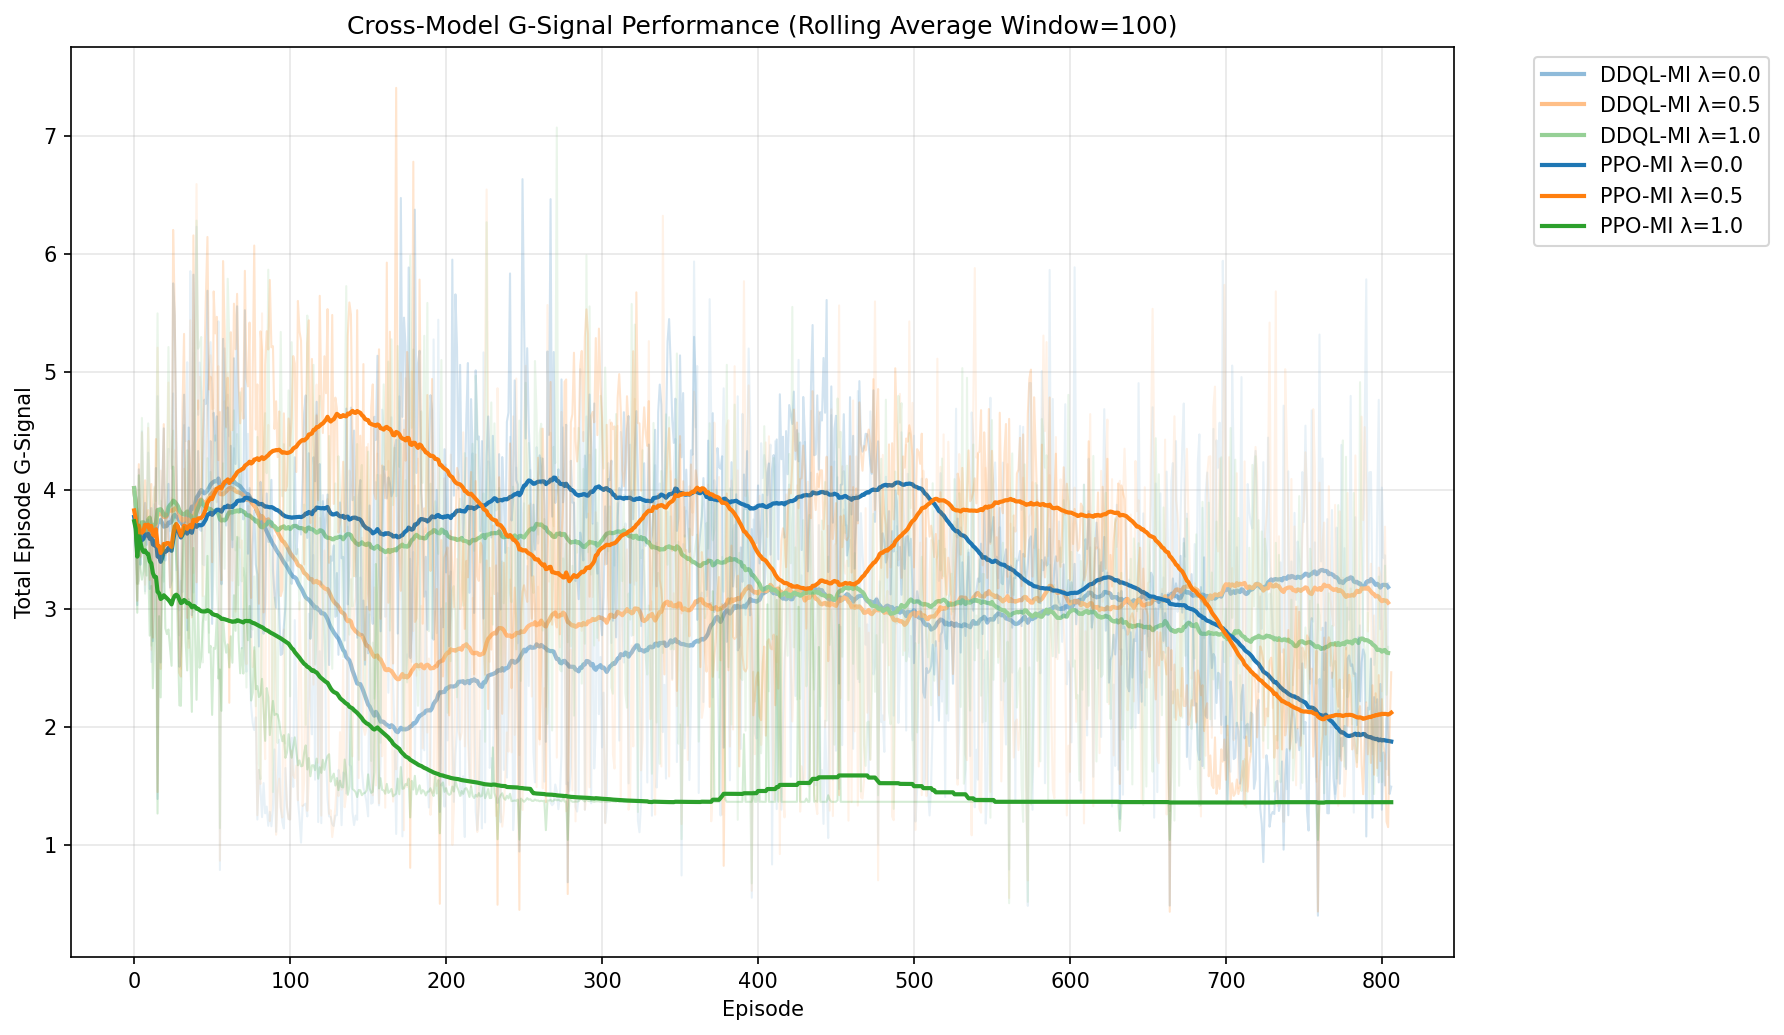

[2025-08-25 18:39:22:064] 
G-Signal Performance Summary:
[2025-08-25 18:39:22:064] DDQL-MI λ=0.0: 805 episodes, Final 100-episode avg: 3.18
[2025-08-25 18:39:22:064] DDQL-MI λ=0.5: 805 episodes, Final 100-episode avg: 3.05
[2025-08-25 18:39:22:065] DDQL-MI λ=1.0: 805 episodes, Final 100-episode avg: 2.63
[2025-08-25 18:39:22:065] PPO-MI λ=0.0: 807 episodes, Final 100-episode avg: 1.88
[2025-08-25 18:39:22:065] PPO-MI λ=0.5: 807 episodes, Final 100-episode avg: 2.12
[2025-08-25 18:39:22:065] PPO-MI λ=1.0: 807 episodes, Final 100-episode avg: 1.37


<Figure size 640x480 with 0 Axes>

In [12]:
# Plot cross-model g-signal performance
fig_g_signal = plot_cross_model_episodic_g_signal(
    all_training_data, 
    window_size=100, 
    show=True, 
    save_path=output_folder / "cross_model_g_signal_performance.svg"
)

Create plots for each pair ("continuous", "discrete") action space, with different lambda

In [14]:
def plot_action_space_comparison_rewards(all_training_data, lambda_value, window_size=100, show=True, save_path=None):
    """
    Plots episodic reward comparison between continuous and discrete action spaces for a specific lambda value.
    
    Args:
        all_training_data: dict with keys (action_space, lambda_value) and values (episode_metadata_df, episode_info_dfs)
        lambda_value: str, the lambda value to compare (e.g., "0.0", "0.5", "1.0")
        window_size: int, window for rolling average (default: 100)
        show: bool, whether to show plot (default: True)
        save_path: str or None, path to save figure (default: None)
    """
    
    # Extract reward data for the specified lambda value
    comparison_data = {}
    
    for key, (episode_metadata_df, episode_info_dfs) in all_training_data.items():
        action_space, lam = key
        if lam == lambda_value and episode_info_dfs is not None and len(episode_info_dfs) > 0:
            
            # Calculate total reward per episode
            episode_rewards = []
            for episode_df in episode_info_dfs:
                if 'reward' in episode_df.columns:
                    total_reward = episode_df['reward'].sum()
                    episode_rewards.append(total_reward)
            
            if episode_rewards:
                # Map action space to algorithm name
                algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
                comparison_data[action_space] = {
                    'rewards': episode_rewards,
                    'label': f'{algo_name} λ={lambda_value}'
                }
    
    if len(comparison_data) == 0:
        print_log(f"No valid training data found for lambda={lambda_value}.")
        return None
    
    # Get consistent color for this lambda value (same as used in cross-model plots)
    unique_lambdas = ["0.0", "0.5", "1.0"]  # Consistent ordering
    base_palette = sns.color_palette('tab10', n_colors=len(unique_lambdas))
    lambda_color_map = {lam: base_palette[i] for i, lam in enumerate(unique_lambdas)}
    
    base_color = lambda_color_map[lambda_value]
    
    # Define color saturation for action spaces (consistent with previous functions)
    action_space_saturation = {'continuous': 1.0, 'discrete': 0.5}
    
    def adjust_color(color, saturation):
        return tuple([saturation * c + (1-saturation) * 1.0 for c in color])
    
    plt.figure(figsize=(12, 7), dpi=150)
    
    for action_space, data in comparison_data.items():
        rewards = np.array(data['rewards'])
        label = data['label']
        
        # Apply saturation based on action space
        color = adjust_color(base_color, action_space_saturation[action_space])
        
        # Rolling average using pandas rolling
        rewards_series = pd.Series(rewards)
        rolling_avg = rewards_series.rolling(window=window_size, min_periods=1).mean()
        
        # Plot original reward curve (low alpha)
        plt.plot(np.arange(len(rewards)), rewards, color=color, alpha=0.2, linewidth=1)
        
        # Plot rolling average curve (main curve)
        plt.plot(np.arange(len(rewards)), rolling_avg, color=color, alpha=1.0, linewidth=2, label=label)
    
    plt.xlabel('Episode')
    plt.ylabel('Total Episode Reward')
    plt.title(f'Action Space Comparison: Episodic Reward (λ={lambda_value}, Rolling Window={window_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print_log(f"Action space comparison plot (λ={lambda_value}) saved to: {save_path}")
    
    if show:
        plt.show()
    
    # Print summary statistics
    print_log(f"\nAction Space Comparison Summary (λ={lambda_value}):")
    for action_space, data in comparison_data.items():
        rewards = np.array(data['rewards'])
        final_avg = pd.Series(rewards).rolling(window=window_size, min_periods=1).mean().iloc[-1]
        algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
        print_log(f"{algo_name} λ={lambda_value}: {len(rewards)} episodes, Final {window_size}-episode avg: {final_avg:.2f}")
    
    return plt.gcf()

[2025-08-14 13:20:55:917] 
[2025-08-14 13:20:55:917] Creating action space comparison plot for λ=0.0
[2025-08-14 13:20:55:917] ==================================================


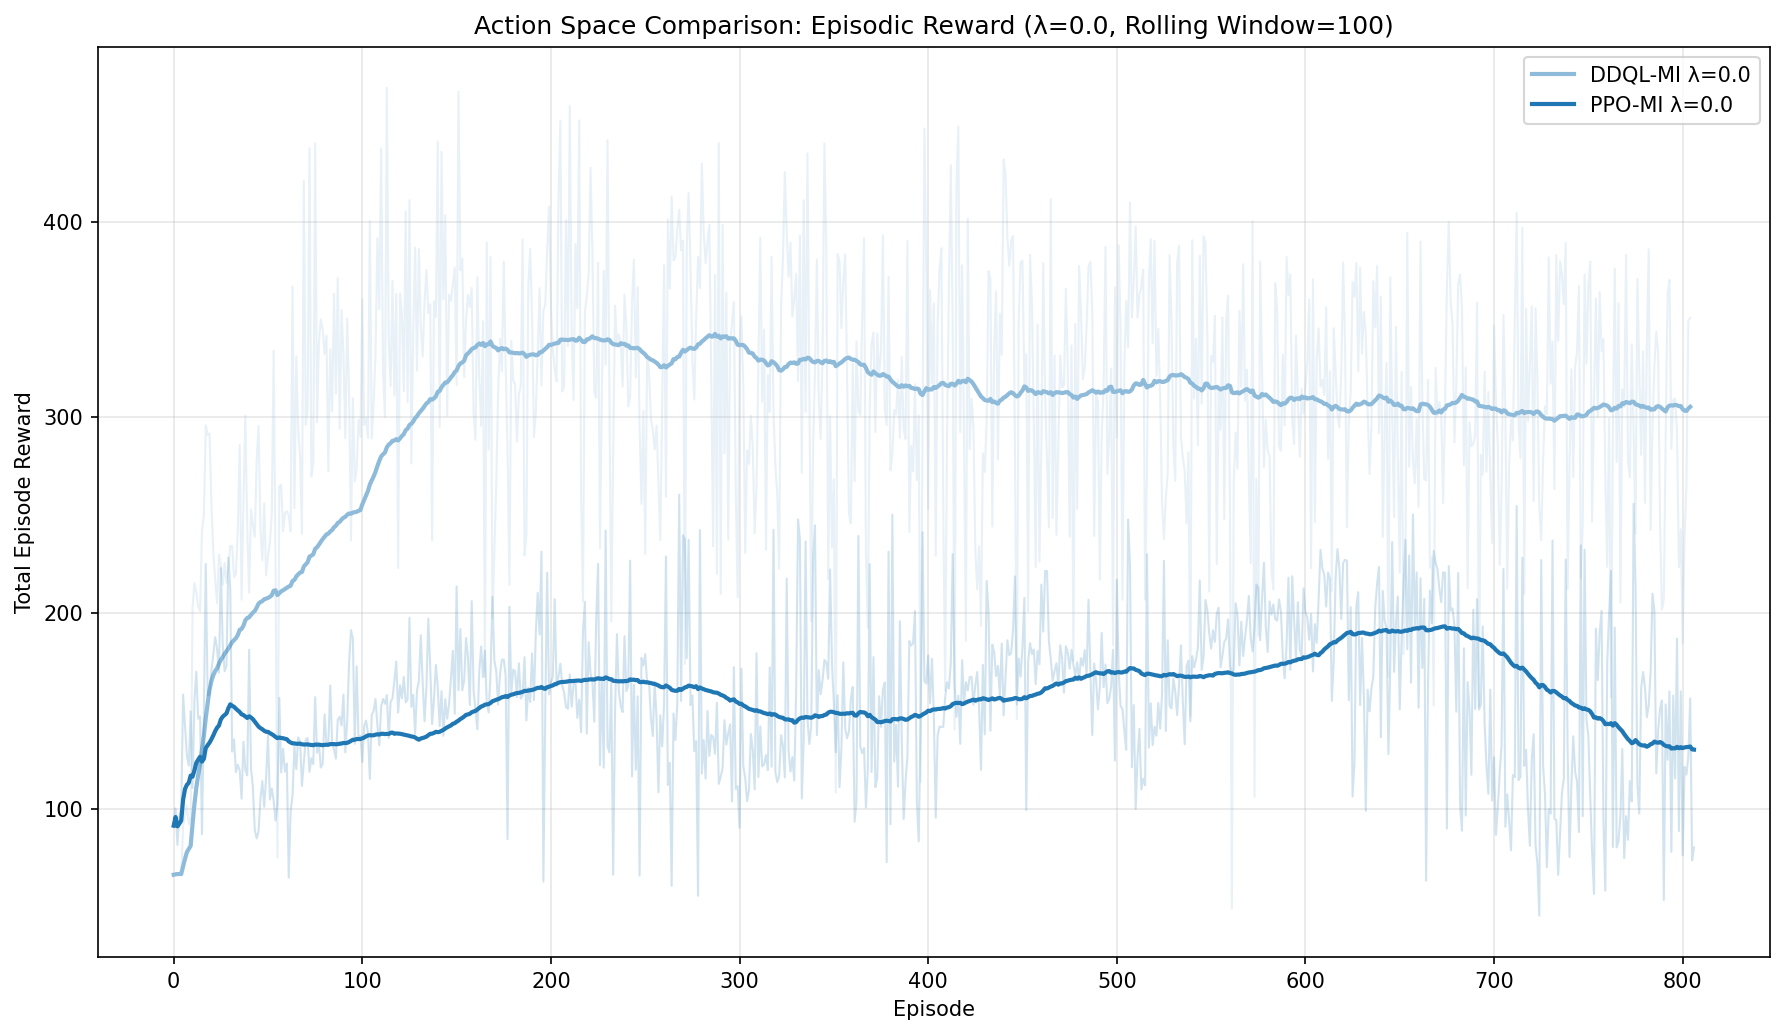

[2025-08-14 13:20:56:083] 
Action Space Comparison Summary (λ=0.0):
[2025-08-14 13:20:56:083] DDQL-MI λ=0.0: 805 episodes, Final 100-episode avg: 305.47
[2025-08-14 13:20:56:084] PPO-MI λ=0.0: 807 episodes, Final 100-episode avg: 130.19
[2025-08-14 13:20:56:084] 
[2025-08-14 13:20:56:084] Creating action space comparison plot for λ=0.5
[2025-08-14 13:20:56:084] ==================================================


<Figure size 640x480 with 0 Axes>

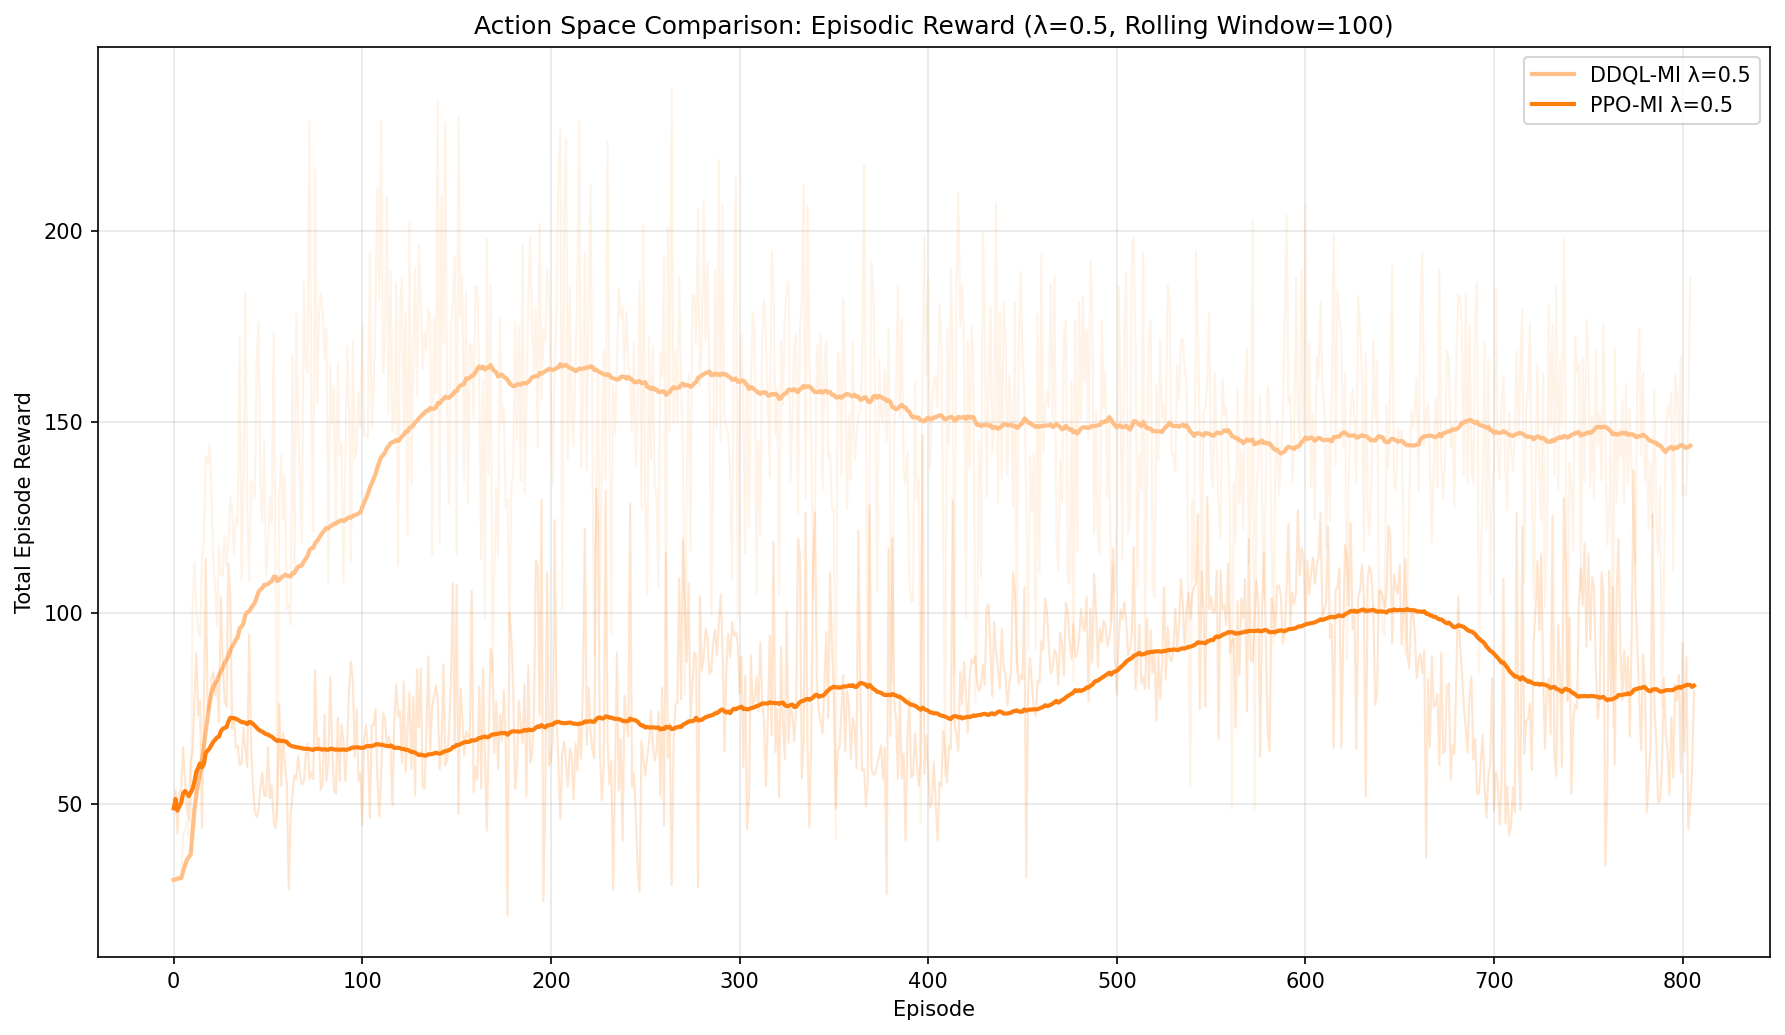

[2025-08-14 13:20:56:250] 
Action Space Comparison Summary (λ=0.5):
[2025-08-14 13:20:56:251] DDQL-MI λ=0.5: 805 episodes, Final 100-episode avg: 143.74
[2025-08-14 13:20:56:251] PPO-MI λ=0.5: 807 episodes, Final 100-episode avg: 80.91
[2025-08-14 13:20:56:252] 
[2025-08-14 13:20:56:252] Creating action space comparison plot for λ=1.0
[2025-08-14 13:20:56:252] ==================================================


<Figure size 640x480 with 0 Axes>

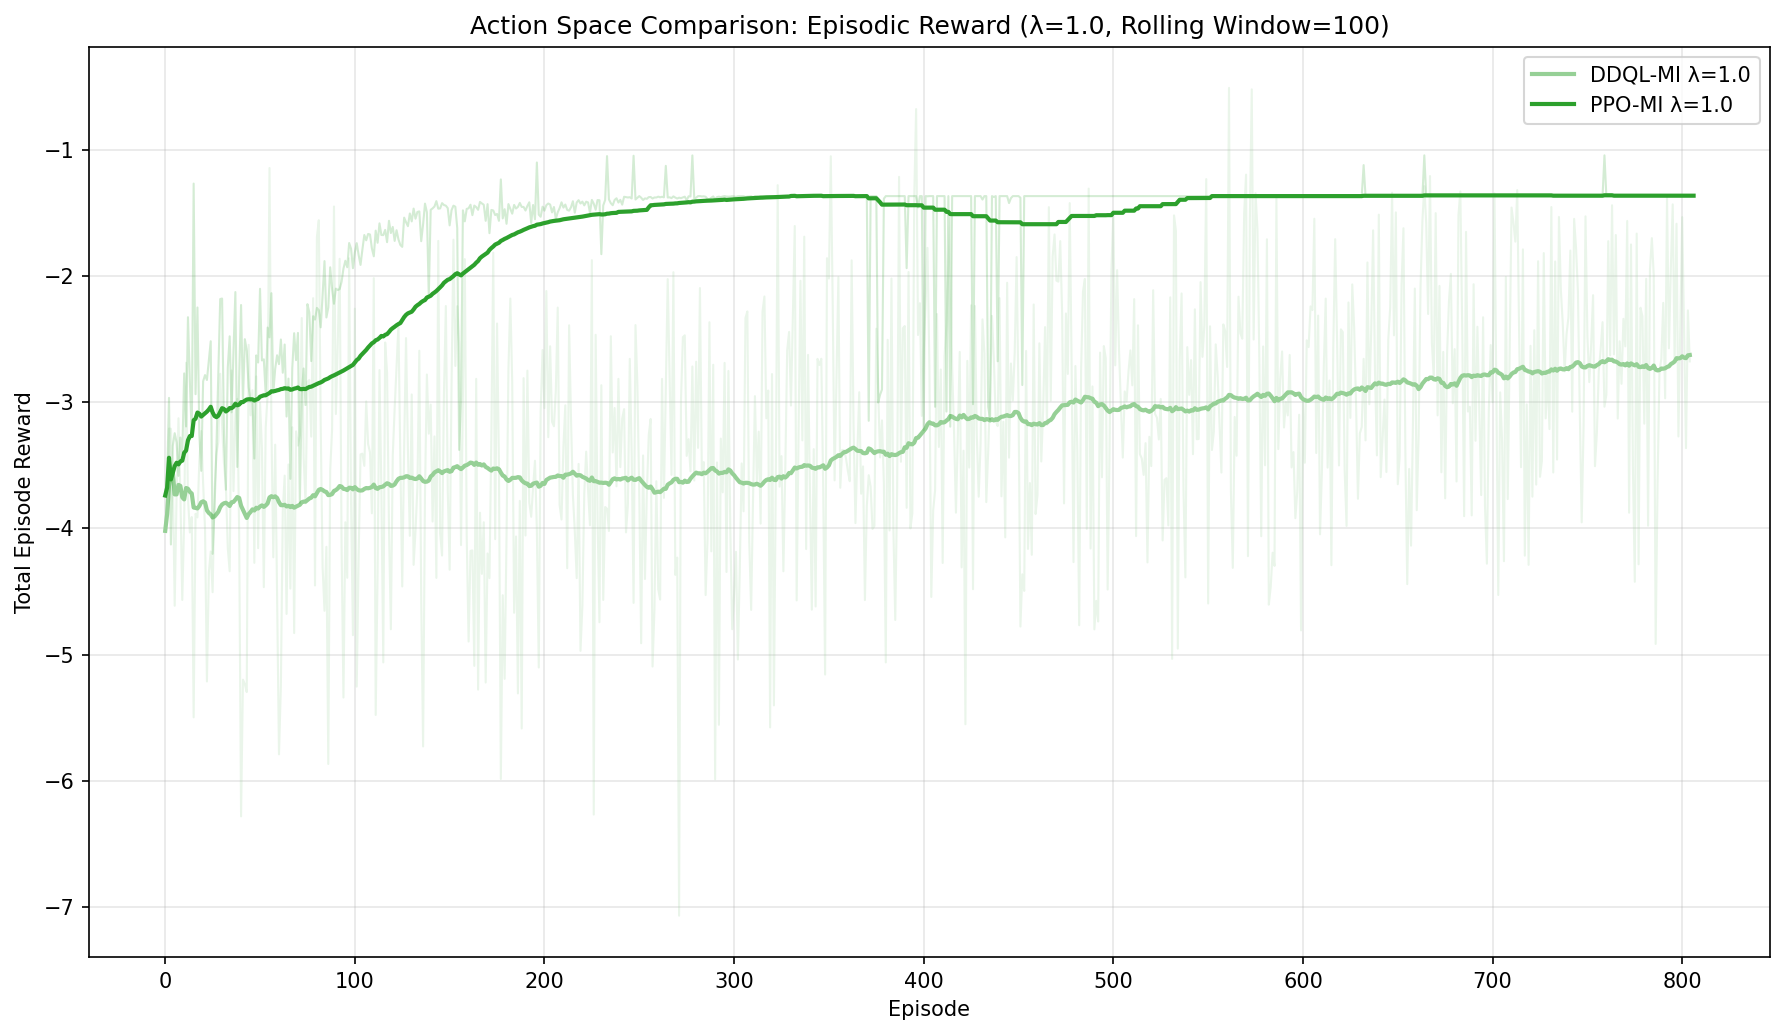

[2025-08-14 13:20:56:415] 
Action Space Comparison Summary (λ=1.0):
[2025-08-14 13:20:56:415] DDQL-MI λ=1.0: 805 episodes, Final 100-episode avg: -2.63
[2025-08-14 13:20:56:415] PPO-MI λ=1.0: 807 episodes, Final 100-episode avg: -1.37


<Figure size 640x480 with 0 Axes>

In [15]:
# Create action space comparison plots for each lambda value
lambda_values = ["0.0", "0.5", "1.0"]

for lam in lambda_values:
    print_log(f"\n{'='*50}")
    print_log(f"Creating action space comparison plot for λ={lam}")
    print_log(f"{'='*50}")
    
    fig = plot_action_space_comparison_rewards(
        all_training_data, 
        lambda_value=lam,
        window_size=100, 
        show=True, 
        save_path=None  # Set to a path if you want to save the plots
    )

In [16]:
def plot_action_space_comparison_f_signal(all_training_data, lambda_value, window_size=100, show=True, save_path=None):
    """
    Plots episodic f-signal comparison between continuous and discrete action spaces for a specific lambda value.
    
    Args:
        all_training_data: dict with keys (action_space, lambda_value) and values (episode_metadata_df, episode_info_dfs)
        lambda_value: str, the lambda value to compare (e.g., "0.0", "0.5", "1.0")
        window_size: int, window for rolling average (default: 100)
        show: bool, whether to show plot (default: True)
        save_path: str or None, path to save figure (default: None)
    """
    
    # Extract f-signal data for the specified lambda value
    comparison_data = {}
    
    for key, (episode_metadata_df, episode_info_dfs) in all_training_data.items():
        action_space, lam = key
        if lam == lambda_value and episode_info_dfs is not None and len(episode_info_dfs) > 0:
            
            # Calculate total f-signal per episode
            episode_f_signals = []
            for episode_df in episode_info_dfs:
                if 'f_signal' in episode_df.columns:
                    total_f_signal = episode_df['f_signal'].sum()
                    episode_f_signals.append(total_f_signal)
            
            if episode_f_signals:
                # Map action space to algorithm name
                algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
                comparison_data[action_space] = {
                    'f_signals': episode_f_signals,
                    'label': f'{algo_name} λ={lambda_value}'
                }
    
    if len(comparison_data) == 0:
        print_log(f"No valid f-signal data found for lambda={lambda_value}.")
        return None
    
    # Get consistent color for this lambda value (same as used in cross-model plots)
    unique_lambdas = ["0.0", "0.5", "1.0"]  # Consistent ordering
    base_palette = sns.color_palette('tab10', n_colors=len(unique_lambdas))
    lambda_color_map = {lam: base_palette[i] for i, lam in enumerate(unique_lambdas)}
    
    base_color = lambda_color_map[lambda_value]
    
    # Define color saturation for action spaces (consistent with previous functions)
    action_space_saturation = {'continuous': 1.0, 'discrete': 0.5}
    
    def adjust_color(color, saturation):
        return tuple([saturation * c + (1-saturation) * 1.0 for c in color])
    
    plt.figure(figsize=(12, 7), dpi=150)
    
    for action_space, data in comparison_data.items():
        f_signals = np.array(data['f_signals'])
        label = data['label']
        
        # Apply saturation based on action space
        color = adjust_color(base_color, action_space_saturation[action_space])
        
        # Rolling average using pandas rolling
        f_signals_series = pd.Series(f_signals)
        rolling_avg = f_signals_series.rolling(window=window_size, min_periods=1).mean()
        
        # Plot original f-signal curve (low alpha)
        plt.plot(np.arange(len(f_signals)), f_signals, color=color, alpha=0.2, linewidth=1)
        
        # Plot rolling average curve (main curve)
        plt.plot(np.arange(len(f_signals)), rolling_avg, color=color, alpha=1.0, linewidth=2, label=label)
    
    plt.xlabel('Episode')
    plt.ylabel('Total Episode F-Signal')
    plt.title(f'Action Space Comparison: F-Signal (λ={lambda_value}, Rolling Window={window_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print_log(f"F-signal action space comparison plot (λ={lambda_value}) saved to: {save_path}")
    
    if show:
        plt.show()
    
    # Print summary statistics
    print_log(f"\nF-Signal Action Space Comparison Summary (λ={lambda_value}):")
    for action_space, data in comparison_data.items():
        f_signals = np.array(data['f_signals'])
        final_avg = pd.Series(f_signals).rolling(window=window_size, min_periods=1).mean().iloc[-1]
        algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
        print_log(f"{algo_name} λ={lambda_value}: {len(f_signals)} episodes, Final {window_size}-episode avg: {final_avg:.2f}")
    
    return plt.gcf()

[2025-08-14 13:21:03:220] 
[2025-08-14 13:21:03:220] Creating f-signal action space comparison plot for λ=0.0
[2025-08-14 13:21:03:220] ==================================================


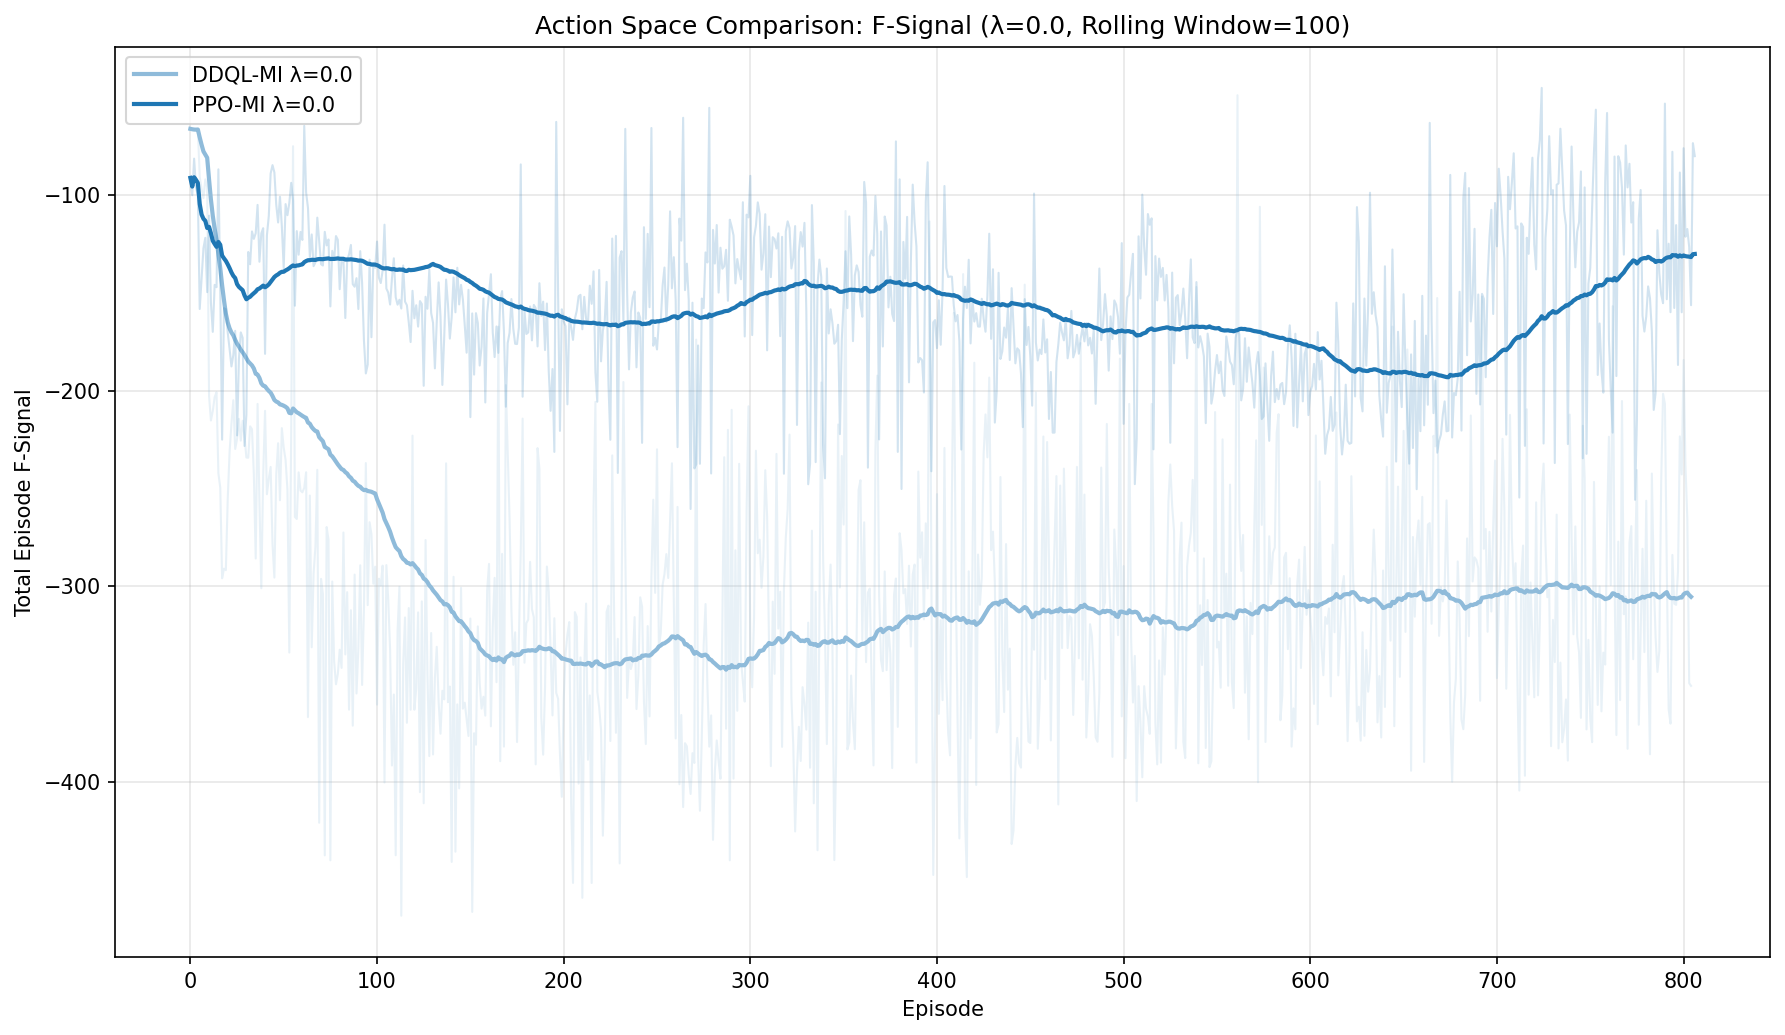

[2025-08-14 13:21:03:387] 
F-Signal Action Space Comparison Summary (λ=0.0):
[2025-08-14 13:21:03:387] DDQL-MI λ=0.0: 805 episodes, Final 100-episode avg: -305.47
[2025-08-14 13:21:03:388] PPO-MI λ=0.0: 807 episodes, Final 100-episode avg: -130.19
[2025-08-14 13:21:03:388] 
[2025-08-14 13:21:03:388] Creating f-signal action space comparison plot for λ=0.5
[2025-08-14 13:21:03:388] ==================================================


<Figure size 640x480 with 0 Axes>

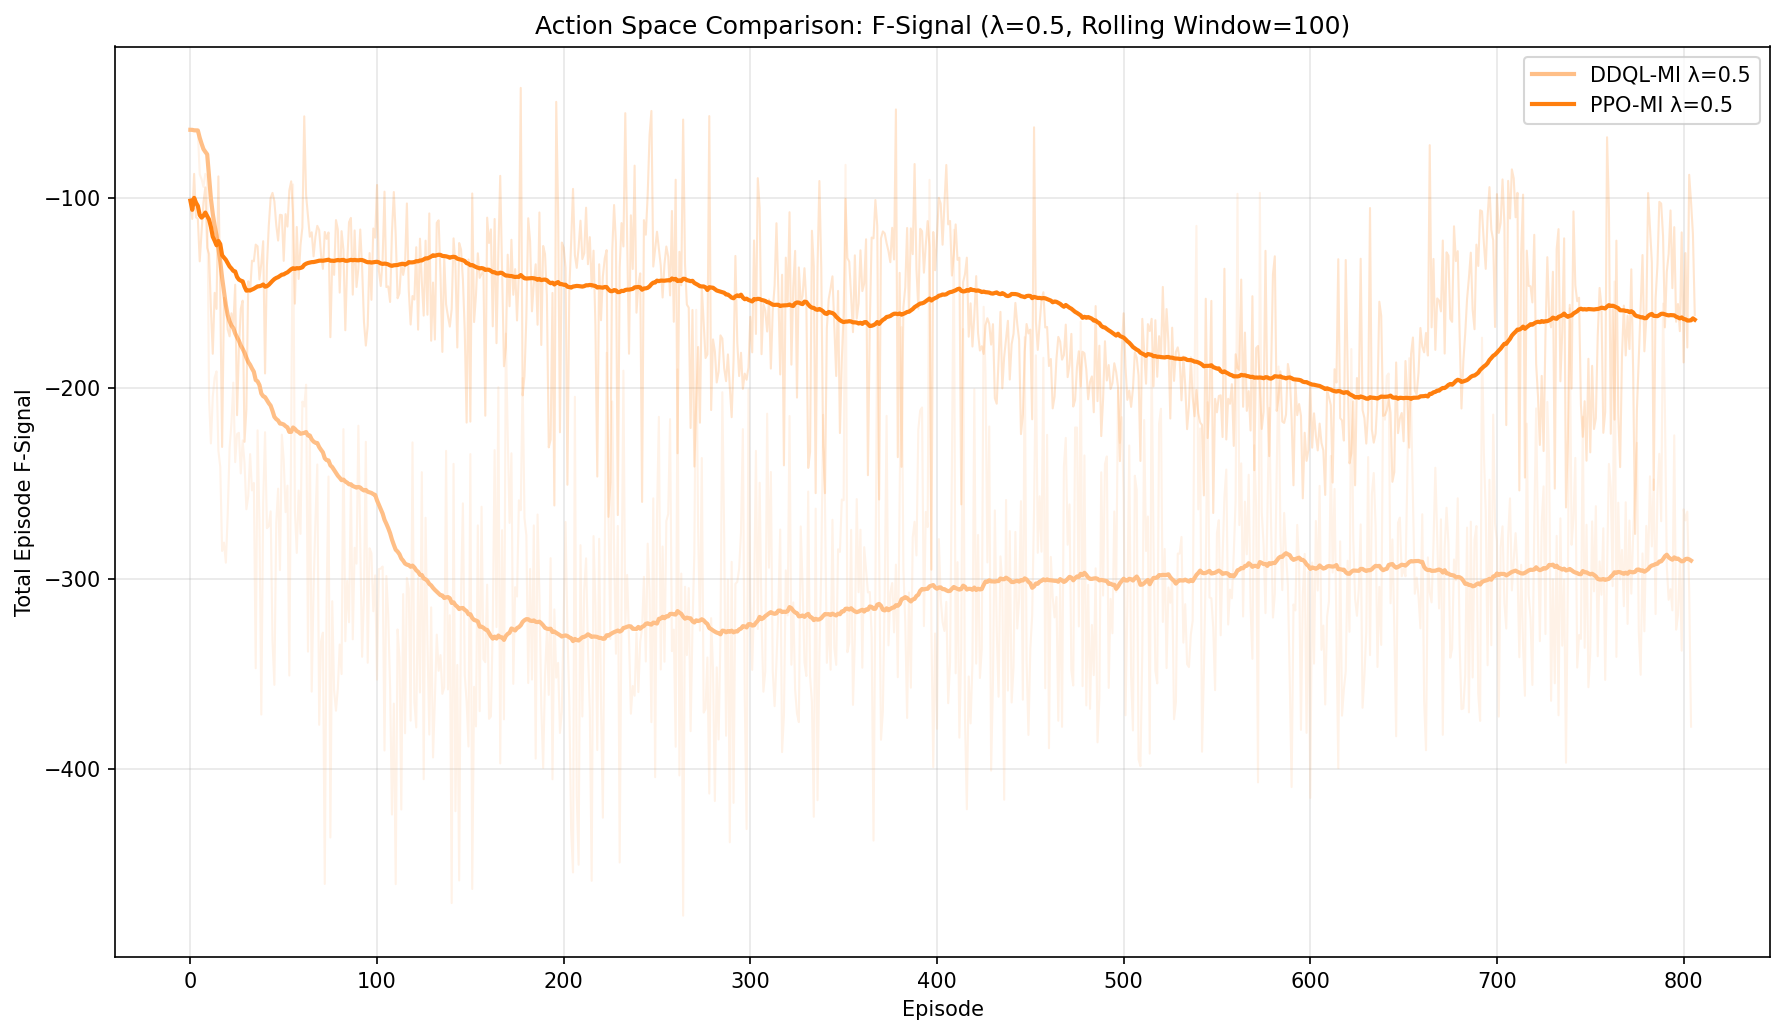

[2025-08-14 13:21:03:565] 
F-Signal Action Space Comparison Summary (λ=0.5):
[2025-08-14 13:21:03:566] DDQL-MI λ=0.5: 805 episodes, Final 100-episode avg: -290.54
[2025-08-14 13:21:03:566] PPO-MI λ=0.5: 807 episodes, Final 100-episode avg: -163.94
[2025-08-14 13:21:03:566] 
[2025-08-14 13:21:03:566] Creating f-signal action space comparison plot for λ=1.0
[2025-08-14 13:21:03:566] ==================================================


<Figure size 640x480 with 0 Axes>

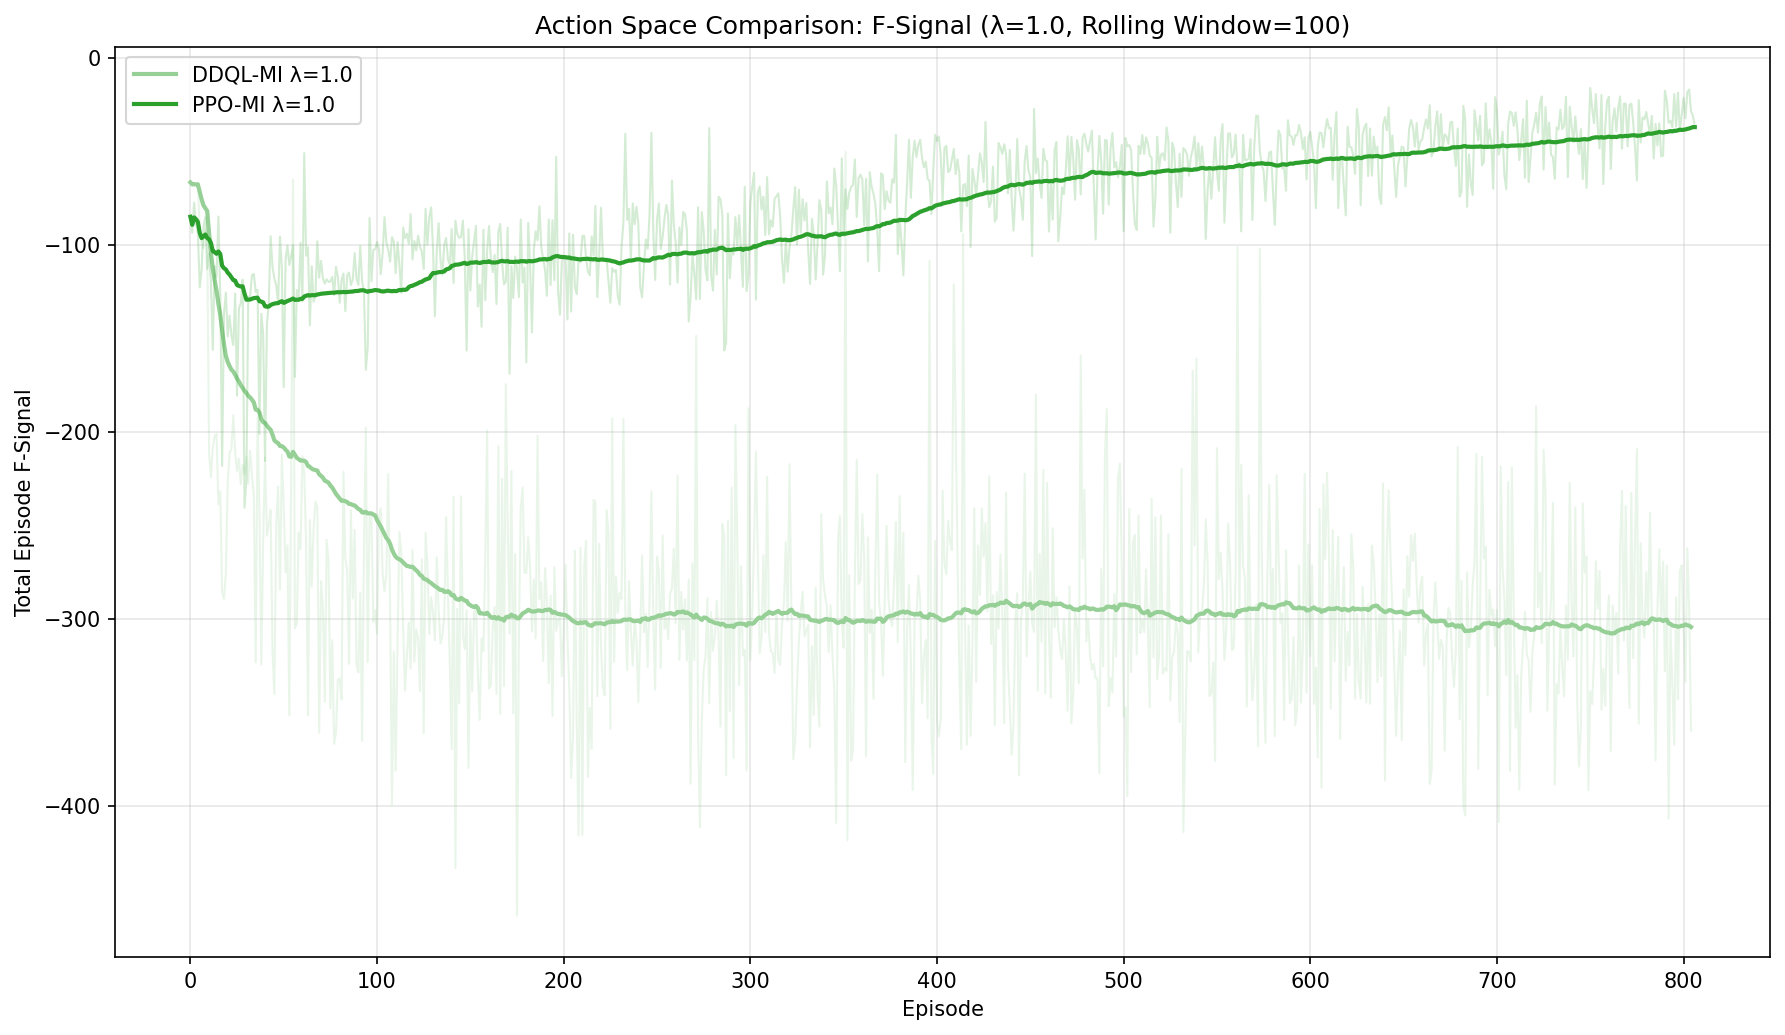

[2025-08-14 13:21:03:735] 
F-Signal Action Space Comparison Summary (λ=1.0):
[2025-08-14 13:21:03:735] DDQL-MI λ=1.0: 805 episodes, Final 100-episode avg: -304.38
[2025-08-14 13:21:03:736] PPO-MI λ=1.0: 807 episodes, Final 100-episode avg: -36.94


<Figure size 640x480 with 0 Axes>

In [17]:
# Create f-signal action space comparison plots for each lambda value
lambda_values = ["0.0", "0.5", "1.0"]

for lam in lambda_values:
    print_log(f"\n{'='*50}")
    print_log(f"Creating f-signal action space comparison plot for λ={lam}")
    print_log(f"{'='*50}")
    
    fig_f = plot_action_space_comparison_f_signal(
        all_training_data, 
        lambda_value=lam,
        window_size=100, 
        show=True, 
        save_path=None  # Set to a path if you want to save the plots
    )

In [18]:
def plot_action_space_comparison_g_signal(all_training_data, lambda_value, window_size=100, show=True, save_path=None):
    """
    Plots episodic g-signal comparison between continuous and discrete action spaces for a specific lambda value.
    
    Args:
        all_training_data: dict with keys (action_space, lambda_value) and values (episode_metadata_df, episode_info_dfs)
        lambda_value: str, the lambda value to compare (e.g., "0.0", "0.5", "1.0")
        window_size: int, window for rolling average (default: 100)
        show: bool, whether to show plot (default: True)
        save_path: str or None, path to save figure (default: None)
    """
    
    # Extract g-signal data for the specified lambda value
    comparison_data = {}
    
    for key, (episode_metadata_df, episode_info_dfs) in all_training_data.items():
        action_space, lam = key
        if lam == lambda_value and episode_info_dfs is not None and len(episode_info_dfs) > 0:
            
            # Calculate total g-signal per episode
            episode_g_signals = []
            for episode_df in episode_info_dfs:
                if 'g_signal' in episode_df.columns:
                    total_g_signal = episode_df['g_signal'].sum()
                    episode_g_signals.append(total_g_signal)
            
            if episode_g_signals:
                # Map action space to algorithm name
                algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
                comparison_data[action_space] = {
                    'g_signals': episode_g_signals,
                    'label': f'{algo_name} λ={lambda_value}'
                }
    
    if len(comparison_data) == 0:
        print_log(f"No valid g-signal data found for lambda={lambda_value}.")
        return None
    
    # Get consistent color for this lambda value (same as used in cross-model plots)
    unique_lambdas = ["0.0", "0.5", "1.0"]  # Consistent ordering
    base_palette = sns.color_palette('tab10', n_colors=len(unique_lambdas))
    lambda_color_map = {lam: base_palette[i] for i, lam in enumerate(unique_lambdas)}
    
    base_color = lambda_color_map[lambda_value]
    
    # Define color saturation for action spaces (consistent with previous functions)
    action_space_saturation = {'continuous': 1.0, 'discrete': 0.5}
    
    def adjust_color(color, saturation):
        return tuple([saturation * c + (1-saturation) * 1.0 for c in color])
    
    plt.figure(figsize=(12, 7), dpi=150)
    
    for action_space, data in comparison_data.items():
        g_signals = np.array(data['g_signals'])
        label = data['label']
        
        # Apply saturation based on action space
        color = adjust_color(base_color, action_space_saturation[action_space])
        
        # Rolling average using pandas rolling
        g_signals_series = pd.Series(g_signals)
        rolling_avg = g_signals_series.rolling(window=window_size, min_periods=1).mean()
        
        # Plot original g-signal curve (low alpha)
        plt.plot(np.arange(len(g_signals)), g_signals, color=color, alpha=0.2, linewidth=1)
        
        # Plot rolling average curve (main curve)
        plt.plot(np.arange(len(g_signals)), rolling_avg, color=color, alpha=1.0, linewidth=2, label=label)
    
    plt.xlabel('Episode')
    plt.ylabel('Total Episode G-Signal')
    plt.title(f'Action Space Comparison: G-Signal (λ={lambda_value}, Rolling Window={window_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print_log(f"G-signal action space comparison plot (λ={lambda_value}) saved to: {save_path}")
    
    if show:
        plt.show()
    
    # Print summary statistics
    print_log(f"\nG-Signal Action Space Comparison Summary (λ={lambda_value}):")
    for action_space, data in comparison_data.items():
        g_signals = np.array(data['g_signals'])
        final_avg = pd.Series(g_signals).rolling(window=window_size, min_periods=1).mean().iloc[-1]
        algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
        print_log(f"{algo_name} λ={lambda_value}: {len(g_signals)} episodes, Final {window_size}-episode avg: {final_avg:.2f}")
    
    return plt.gcf()

[2025-08-14 13:21:05:384] 
[2025-08-14 13:21:05:384] Creating g-signal action space comparison plot for λ=0.0
[2025-08-14 13:21:05:384] ==================================================


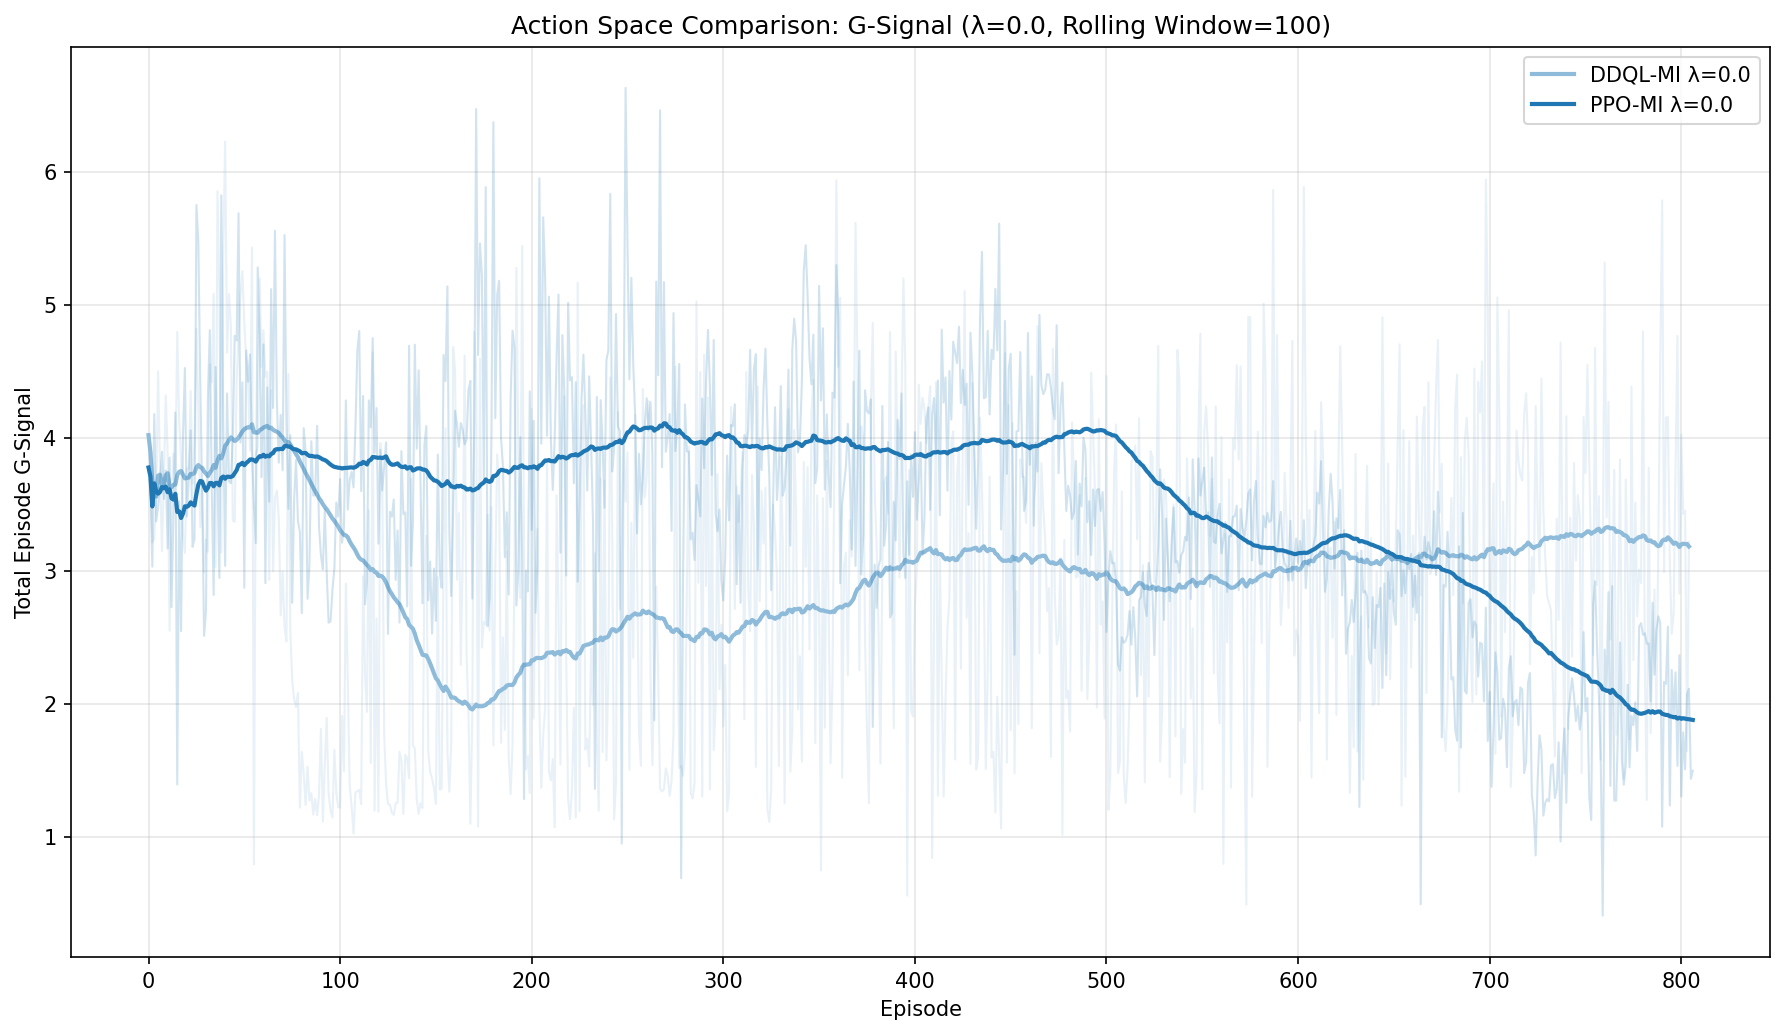

[2025-08-14 13:21:05:559] 
G-Signal Action Space Comparison Summary (λ=0.0):
[2025-08-14 13:21:05:559] DDQL-MI λ=0.0: 805 episodes, Final 100-episode avg: 3.18
[2025-08-14 13:21:05:560] PPO-MI λ=0.0: 807 episodes, Final 100-episode avg: 1.88
[2025-08-14 13:21:05:560] 
[2025-08-14 13:21:05:560] Creating g-signal action space comparison plot for λ=0.5
[2025-08-14 13:21:05:560] ==================================================


<Figure size 640x480 with 0 Axes>

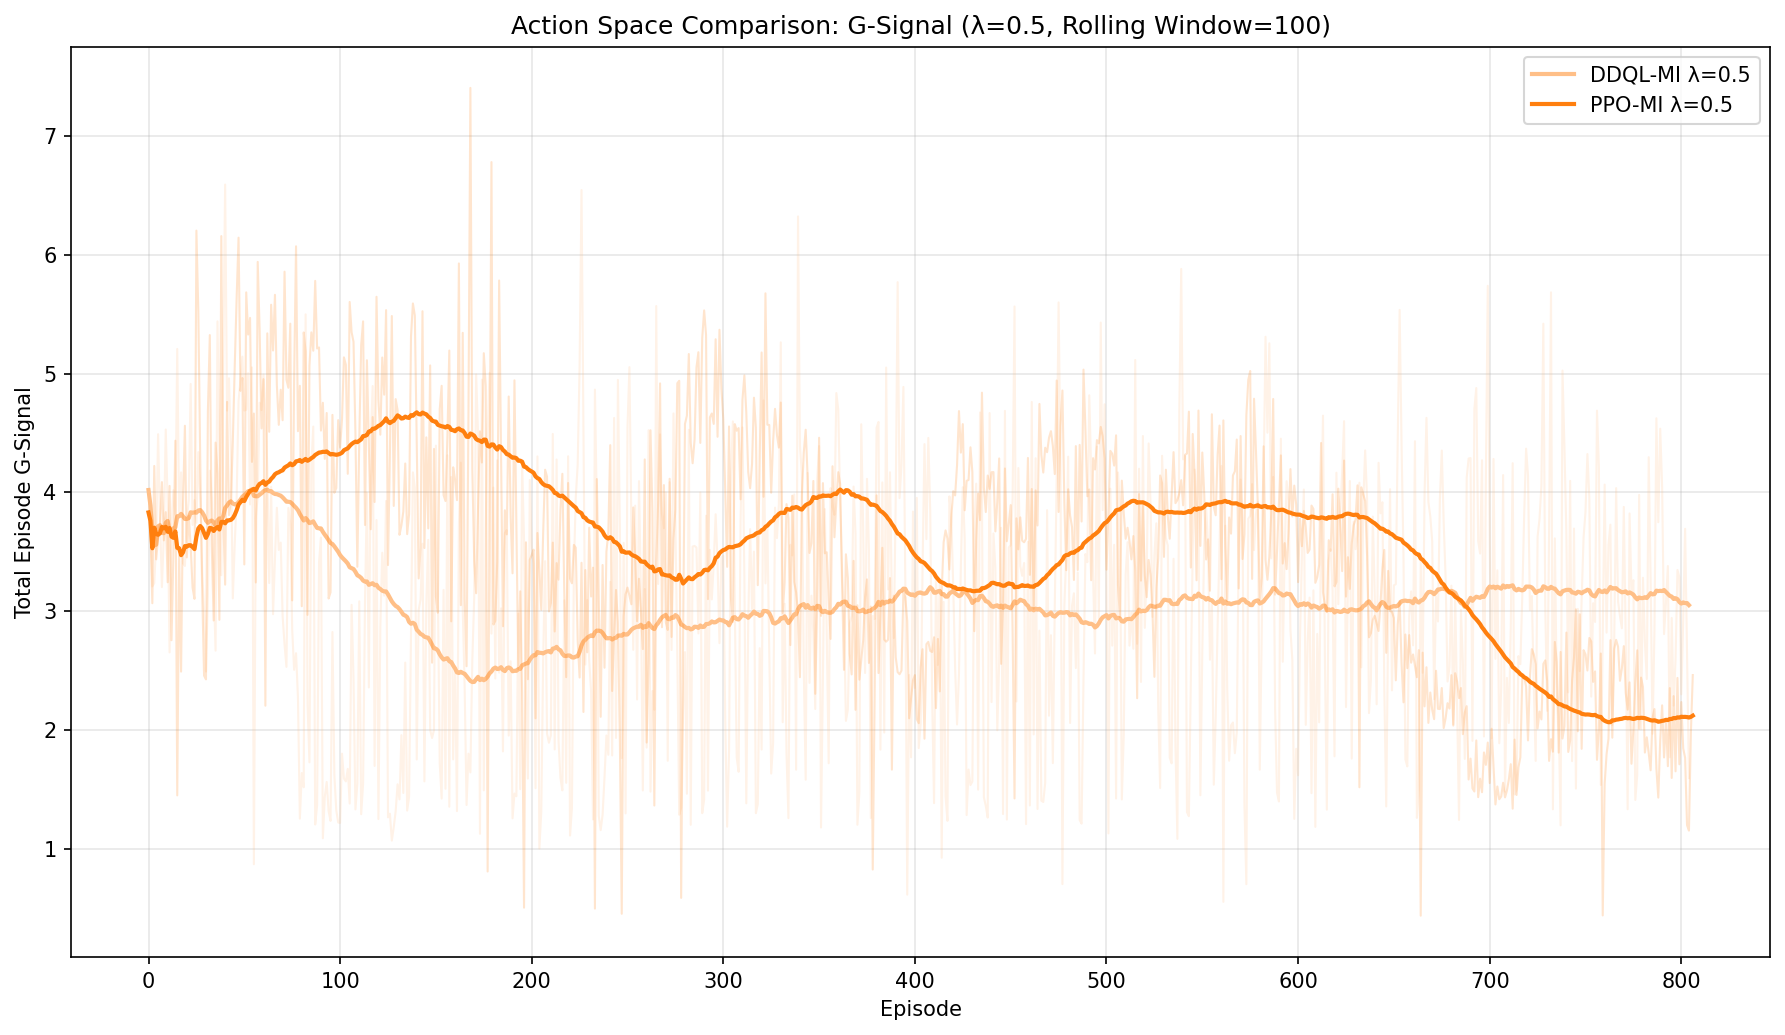

[2025-08-14 13:21:05:747] 
G-Signal Action Space Comparison Summary (λ=0.5):
[2025-08-14 13:21:05:747] DDQL-MI λ=0.5: 805 episodes, Final 100-episode avg: 3.05
[2025-08-14 13:21:05:747] PPO-MI λ=0.5: 807 episodes, Final 100-episode avg: 2.12
[2025-08-14 13:21:05:748] 
[2025-08-14 13:21:05:748] Creating g-signal action space comparison plot for λ=1.0
[2025-08-14 13:21:05:748] ==================================================


<Figure size 640x480 with 0 Axes>

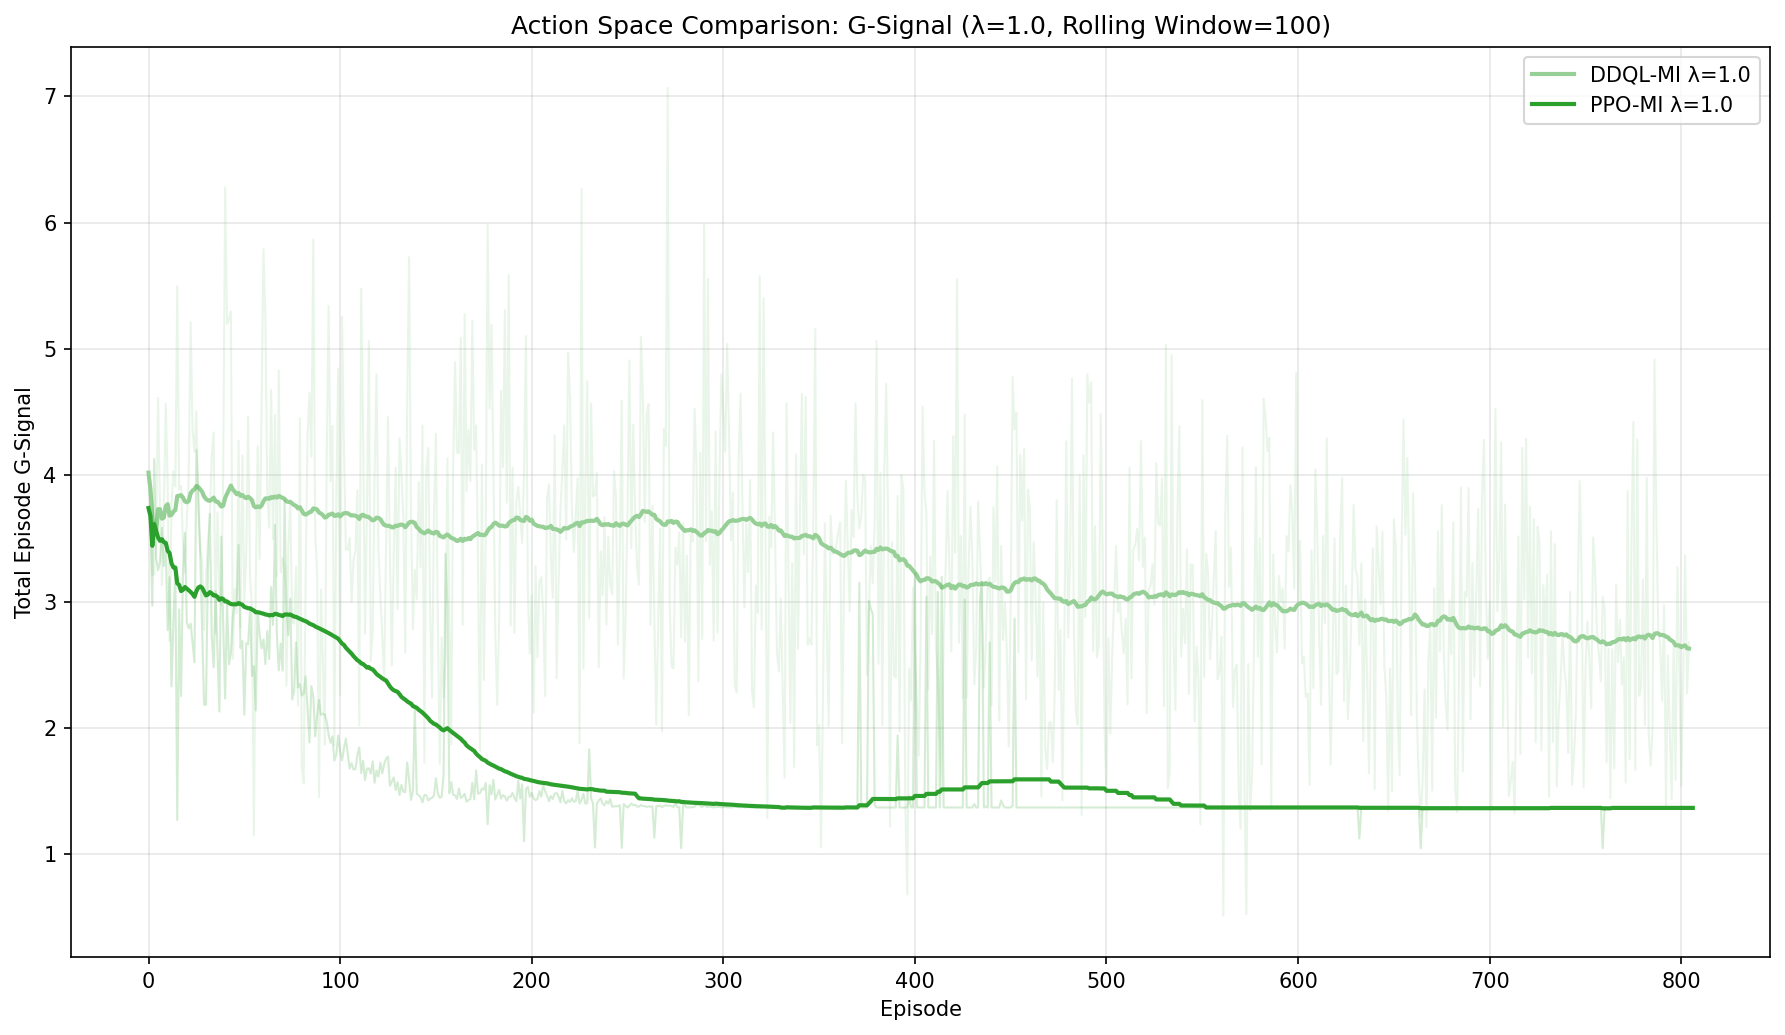

[2025-08-14 13:21:05:913] 
G-Signal Action Space Comparison Summary (λ=1.0):
[2025-08-14 13:21:05:914] DDQL-MI λ=1.0: 805 episodes, Final 100-episode avg: 2.63
[2025-08-14 13:21:05:914] PPO-MI λ=1.0: 807 episodes, Final 100-episode avg: 1.37


<Figure size 640x480 with 0 Axes>

In [19]:
# Create g-signal action space comparison plots for each lambda value
lambda_values = ["0.0", "0.5", "1.0"]

for lam in lambda_values:
    print_log(f"\n{'='*50}")
    print_log(f"Creating g-signal action space comparison plot for λ={lam}")
    print_log(f"{'='*50}")
    
    fig_g = plot_action_space_comparison_g_signal(
        all_training_data, 
        lambda_value=lam,
        window_size=100, 
        show=True, 
        save_path=None  # Set to a path if you want to save the plots
    )